In [1]:
%matplotlib widget

In [2]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy.interpolate import interp1d
from pathlib import Path
import flammkuchen as fl
from tqdm import tqdm
from scipy import ndimage
import flammkuchen as fl
import seaborn as sns
from scipy.stats import zscore
import json
import imageio
from scipy.signal import medfilt, convolve, detrend
from scipy.spatial.distance import euclidean
from scipy.ndimage import zoom
from skimage import exposure
from scipy.ndimage import gaussian_filter as gf
from matplotlib.colors import ListedColormap
from scipy.stats import circmean
from matplotlib import cm
from scipy.signal import savgol_filter as sgf
from bouter.utilities import fast_pearson
from scipy.stats import spearmanr
from sklearn.cluster import KMeans as km
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.stats import sem
import random
from scipy.signal import detrend

In [19]:
def create_bin_sphere(arr_size, center, r):
    coords = np.ogrid[:arr_size[0], :arr_size[1], :arr_size[2]]
    distance = np.sqrt((coords[0] - center[0])**2 + (coords[1]-center[1])**2 + (coords[2]-center[2])**2) 
    return 1*(distance <= r)

def remove_baseline(x_):
    return sgf((x_ - np.nanmedian(x_[30:80])),9,3)

def compute_temporal_distance(array_):
    where_crop = np.array([[605, 690], [745, 830]])
    ttas_norm = np.zeros(array_.shape)
    coords_out = np.zeros((array_.shape[0],2))
    for i in range(array_.shape[0]):
        norm_array = remove_baseline(array_[i,:])
        ttas_norm[i,:] = norm_array
        coords_out[i,:] = np.array([norm_array[where_crop[0,0]:where_crop[0,1]].mean(),
                                   norm_array[where_crop[1,0]:where_crop[1,1]].mean()])
    return ttas_norm,coords_out

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 
        

In [4]:
reg = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\ValenceProject\salt_calibrated_stimulus.h5")["experiment_trace"]
f = interp1d(np.arange(2400), np.concatenate([reg,[0]]))
res_reg = f(np.arange(0, (4800/2)-.5, 0.5))
res_salt = zscore(np.concatenate([res_reg,[0]]))

In [5]:
x_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\x_proj_png.png")
y_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\y_proj_png.png")
z_proj = imageio.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\z_proj_png.png")

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as i

In [6]:
path_coords = Path(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder")
AO = tifffile.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\AO.tif")
regions_ids = fl.load(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\regions_mask.h5")["array"]
sf_AO = zoom(tifffile.imread(r"C:\Users\ge59xan\Desktop\epaoli\Desktop\CMTK_folder\210504_f1_affine_AO.tif"),(9.6,0.6,0.6))


In [7]:
list_regions = ["rHb","lHb","IPN","DRN","MRN","lLOB","lROB","OT","vSp",
                "mOB","lOE","rOE","dSp","Pa","dTh","PT","PO","Cb","dHind",
               "vHind","Tor"]
list_files = [Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_1\210504_f1"), #H2b
             Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f0"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_2\210514_f1"), #H2b
            Path(r"U:\experiments\virtual_gradients_experiments\Batch_4\210607_f0")]#H2b 

In [8]:
radius_rois = 15
hard_th = .3
corr_th = .3
pval_th = 0.025
min_overlap_cells_pval = 5
min_overlap_cells_nopval = 10
color_array = plt.cm.Reds(np.linspace(0,1,1000))
color_array = ListedColormap(color_array[:1000,:])
vmin = None
vmax=None
alpha = .8
xy_res = .6
z_res = 9.6
zjitter = 20

In [9]:
results_params = []
results_coords = []
results_pvals = []
results_traces = []

results_traces_temp = []
results_traces_salt = []

for n_fish in tqdm(range(len(list_files))):
    
    fish_path = list_files[n_fish]
    
    full_traces_temp = zscore(fl.load(fish_path / "imaging" /"temp"/ "traces.h5")['traces'],1)
    
    data_integration = fl.load(fish_path / "imaging" /"temp"/ "behavioural_model_fitting_v02.h5")
    ev_integration = data_integration["fitting"][:,0].copy()
    rois_integration_temp = np.isfinite(data_integration["fitting"][:,0])&(data_integration["coordinates"][:,-1]!=0)&(data_integration["coordinates"][:,-1]!=11)&(data_integration["coordinates"][:,-1]!=12)
    theta_space_temp = data_integration["ttas"]
    
    full_traces_salt = zscore(fl.load(fish_path / "imaging" /"salt"/ "traces.h5")['traces'],1)
    data_integration = fl.load(fish_path / "imaging" /"salt"/ "behavioural_model_fitting_v02.h5")
    ev_integration = data_integration["fitting"][:,0].copy()
    rois_integration_salt = np.isfinite(data_integration["fitting"][:,0])&(data_integration["coordinates"][:,-1]!=0)&(data_integration["coordinates"][:,-1]!=11)&(data_integration["coordinates"][:,-1]!=12)
    theta_space_salt = data_integration["ttas"]    
    
    rois_integration_multisens = rois_integration_salt & rois_integration_temp
    pearson = np.zeros(rois_integration_multisens.sum())
    correlations = np.zeros(rois_integration_multisens.sum())
    for i in range(rois_integration_multisens.sum()):
        x_ = theta_space_temp[rois_integration_multisens,:][i,:]
        y_ = theta_space_salt[rois_integration_multisens,:][i,:]
        c = spearmanr(x_,y_)[0]
        if abs(c) >= hard_th:
            n_shuffles = 1000
            shuffles = np.zeros(n_shuffles)
            for i_shuffle in range(n_shuffles):
                c_shuffle = spearmanr(np.roll(x_,int(np.random.uniform(low=1, high=960, size=(1,))[0])),
                                                 np.roll(y_,int(np.random.uniform(low=1, high=960, size=(1,))[0])))[0]
                shuffles[i_shuffle] = c_shuffle
            if c>0:
                pval = np.sum(shuffles>c) / n_shuffles
            else:
                pval = np.sum(shuffles<c) / n_shuffles
        else:
            pval=1
        pearson[i] = pval
        correlations[i] = c
    results_coords.append(data_integration["coordinates"][rois_integration_multisens,:-1])
    results_params.append(correlations)
    results_pvals.append(pearson)
    results_traces.append(np.stack([theta_space_temp,
          theta_space_salt],0)[:,rois_integration_multisens,:])
    
    results_traces_temp.append(data_integration["coordinates"][rois_integration_temp,:-1])
    results_traces_salt.append(data_integration["coordinates"][rois_integration_salt,:-1])
    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [23:47<00:00, 285.46s/it]


In [12]:
good_coords = np.concatenate(results_coords,0)
correlation_ts = np.concatenate(results_params,0)
p_values = np.concatenate(results_pvals,0)
results_traces_pool = np.concatenate(results_traces,1)

In [11]:
plt.rcParams.update({'font.size': 25})

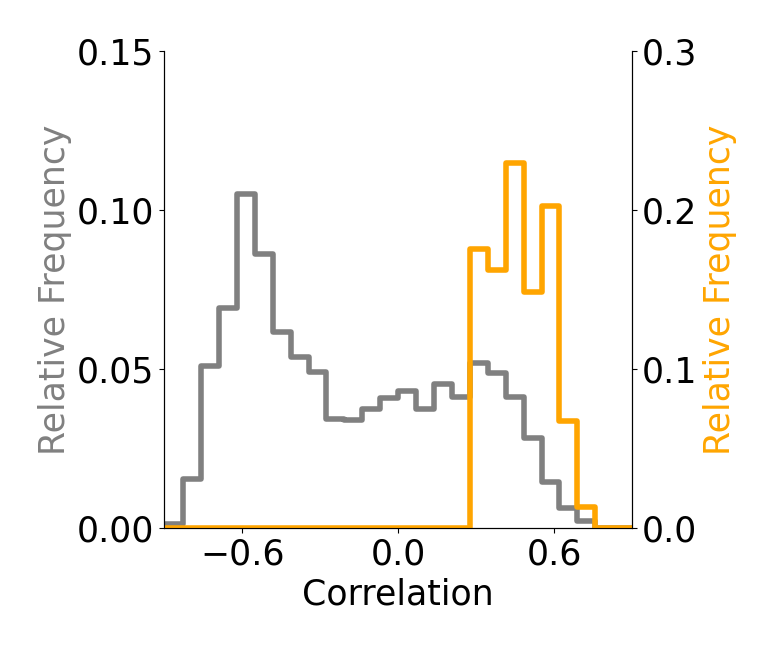

In [75]:
bins = np.linspace(-1,1,30)
f,a = plt.subplots(1,1)
bins_plot = (bins[1:]+bins[:-1])/2
counts,_ = np.histogram(correlation_ts,bins)
counts = counts / np.sum(counts)
a.step(bins_plot,counts,alpha=1,color="gray",lw=4)
a2 = a.twinx()
counts,_ = np.histogram(correlation_ts[(p_values<0.025)&(correlation_ts>.3)],bins)
counts = counts / np.sum(counts)
a2.step(bins_plot,counts,alpha=1,color="orange",lw=4)
a.set_xlim([-.9,.9])
a.set_ylim([0.0,.15])
a.set_xticks([-.6,0,.6],fontsize=25)
a.set_yticks([0,.05,.10,.15],fontsize=25)
a2.set_ylim([0.,.3])
a2.set_yticks([0,.1,.2,.3],fontsize=25)
a.set_ylabel("Relative Frequency",color="gray",fontsize=25)
a2.set_ylabel("Relative Frequency",color="orange",fontsize=25)
a.set_xlabel("Correlation",fontsize=25)
sns.despine(right=False)
set_size(6,5)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\PANELS\supp_4_f_new.png",dpi=800)

In [13]:
good_coords_pos = good_coords[(p_values<pval_th)&((correlation_ts)>corr_th),:]
traces_pos = np.concatenate([results_traces_pool[0,(p_values<pval_th)&((correlation_ts)>corr_th),:],
                             results_traces_pool[1,(p_values<pval_th)&((correlation_ts)>corr_th)]],1)

pool_traces_temp_multi = pool_traces_temp[(p_values<pval_th)&((correlation_ts)>corr_th)]
pool_traces_salt_multi = pool_traces_salt[(p_values<pval_th)&((correlation_ts)>corr_th)]

NameError: name 'pool_traces_temp' is not defined

In [14]:
good_coords_pos.shape[0] / good_coords.shape[0]

0.03432282003710575

In [214]:
### ROIs with p-value filtering

In [134]:
%%time
good_coords_display_pos = good_coords_pos.copy()
good_coords_display_pos[:,0]*=z_res
good_coords_display_pos[:,1:]*=xy_res
jittered_z_pos = good_coords_display_pos[:,0].copy() + np.random.uniform(low=-5, high=5, size=(good_coords_display_pos.shape[0]))
jittered_z_pos[jittered_z_pos<=0] += zjitter
volume_pos = np.zeros(sf_AO.shape)
for i in range(good_coords_display_pos.shape[0]):
    volume_pos+=create_bin_sphere(sf_AO.shape, (jittered_z_pos[i],good_coords_display_pos[i,1],
                                  good_coords_display_pos[i,2]), radius_rois)

Wall time: 46.8 s


In [ ]:
volume = volume_pos.copy()
volume = (volume>min_overlap_cells)*1
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])

ax1.imshow(np.flip(volume.sum(1),0),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1])
ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax3.set_xticks([])
ax3.set_yticks([])
sns.despine(bottom=True,left=True)
plt.show()

In [213]:
### All the ROIs without p-value filtering

In [212]:
%%time
good_coords_display = good_coords.copy()
good_coords_display[:,0]*=z_res
good_coords_display[:,1:]*=xy_res
jittered_z = good_coords_display[:,0].copy() + np.random.uniform(low=-5, high=5, size=(good_coords_display.shape[0]))
jittered_z[jittered_z<=0] += zjitter
volume_all = np.zeros(sf_AO.shape)
for i in range(good_coords_display.shape[0]):
    volume_all+=create_bin_sphere(sf_AO.shape, (jittered_z[i],good_coords_display[i,1],
                                  good_coords_display[i,2]), radius_rois)

Wall time: 24min 3s


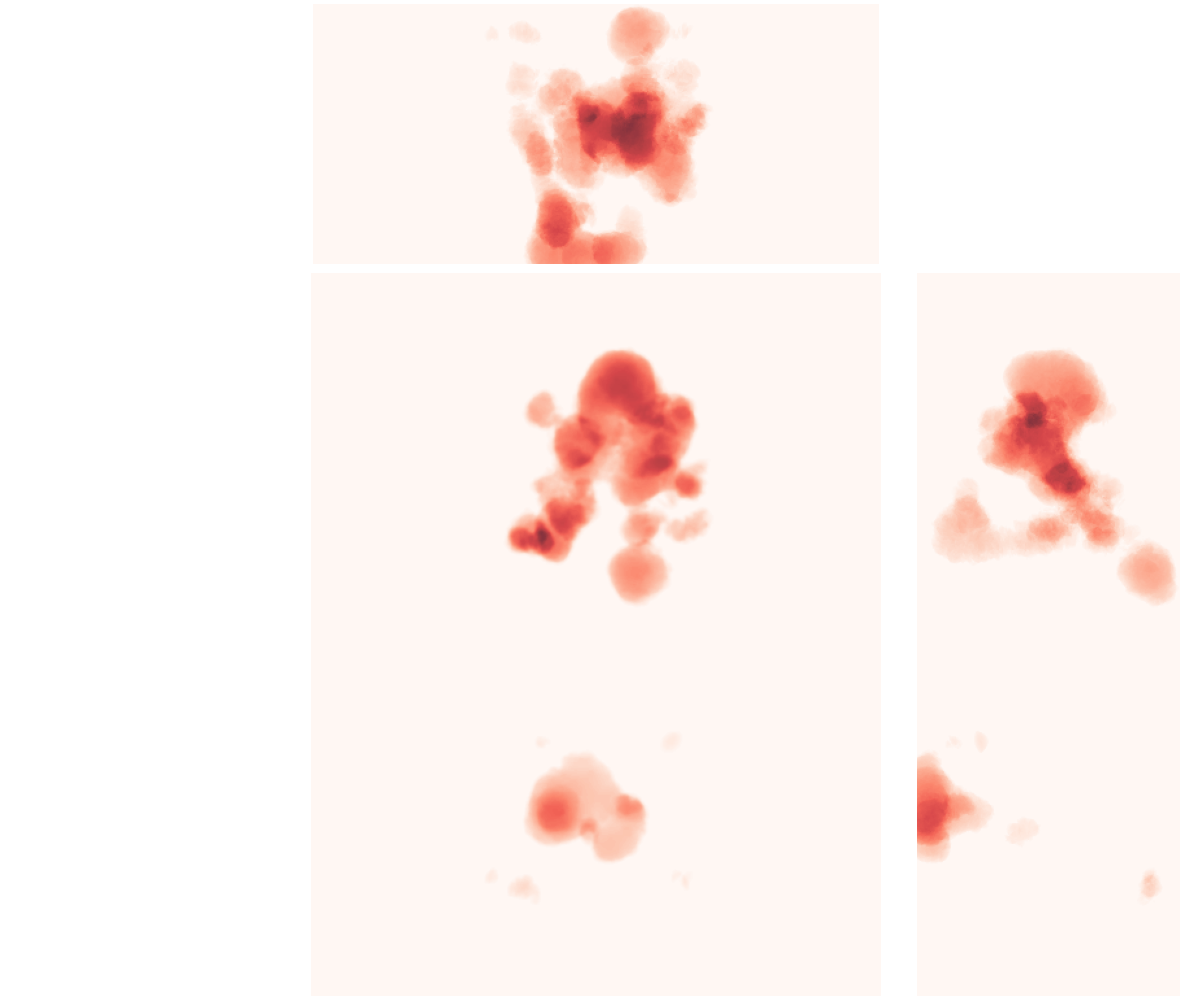

In [222]:
volume = volume_all.copy()
volume = (volume>min_overlap_cells_nopval)*1
fig = plt.figure(figsize=(12, 10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,2,1], height_ratios=[.72,1,1])
ax1 = fig.add_subplot(gs[0,1])

ax1.imshow(np.flip(volume.sum(1),0),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1:,1])
ax2.imshow(gf(np.roll(volume[:,:,:].sum(0),0),1),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[1:,-1])
ax3.imshow(np.rot90(np.flip(volume.sum(2),0),-1),cmap=color_array,alpha=alpha,vmin=vmin, vmax=vmax)

ax3.set_xticks([])
ax3.set_yticks([])
sns.despine(bottom=True,left=True)
plt.show()

In [16]:
n_clust=2
clusters_model = km(n_clust).fit(traces_pos)
cluster_labels = clusters_model.predict(traces_pos)
clusters_mean = np.zeros((n_clust,traces_pos.shape[1]))
clusters_sem = np.zeros((n_clust,traces_pos.shape[1]))
for i in range(n_clust):
    traces_cluster = traces_pos[cluster_labels==i,:]
    first_half = traces_cluster[:,:960]
    second_half = traces_cluster[:,960:]
    for i_trace in range(first_half.shape[0]):
        first_half[i_trace,] = zscore(first_half[i_trace,]) #- first_half[i_trace,:100].mean()
        second_half[i_trace,] = zscore(second_half[i_trace,]) #- second_half[i_trace,:100].mean()
    contatenation = np.concatenate([first_half,second_half],1)
    clusters_mean[i,:] = np.nanmean(contatenation,0)
    clusters_sem[i,:] = sem(contatenation,0)

In [17]:
mean_clusters = []
n_clusters = []
for id_ in list(np.unique(cluster_labels)):
    if (np.sum(cluster_labels==id_)>1) and (id_!=-1):
        mean_clusters.append(remove_baseline(np.nanmedian(traces_pos[cluster_labels==id_,:],0)))
        n_clusters.append(np.sum(cluster_labels==id_))

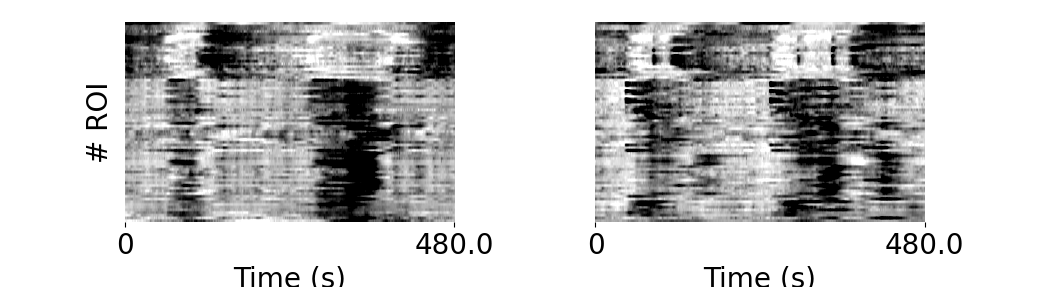

In [46]:
f,a  = plt.subplots(1,2)
a[0].imshow(traces_pos[np.argsort(clusters_idxs),:960],cmap="gray_r",aspect="auto",vmax=1,vmin=-1)
a[1].imshow(traces_pos[np.argsort(clusters_idxs),960:],cmap="gray_r",aspect="auto",vmax=1,vmin=-1)
a[0].set_yticks([], fontsize=20)
a[0].set_xticks([0,960],fontsize=20)
a[0].set_ylabel("# ROI",fontsize=20)
a[0].set_xlabel("Time (s)",fontsize=20)
a[0].set_xticklabels([0,960/2],fontsize=20)
a[1].set_yticks([])
a[1].set_xticks([0,960],fontsize=20)
a[1].set_xticklabels([0,960/2],fontsize=20)
a[1].set_xlabel("Time (s)", fontsize=20)
sns.despine(bottom=True,left=True)
plt.tight_layout()
set_size(8,2)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\fig_3c_newnew.png",dpi=800)

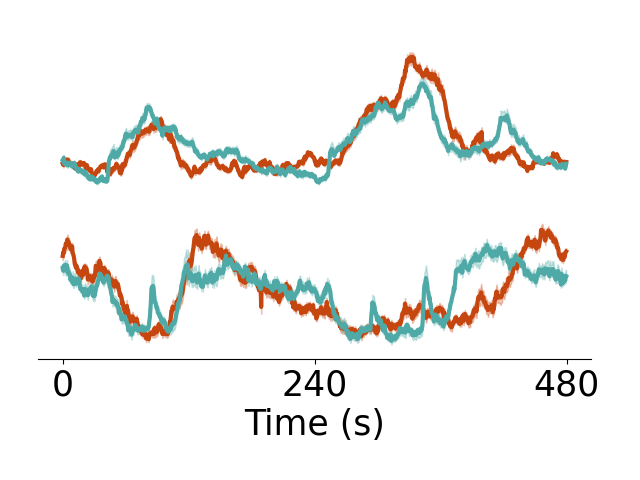

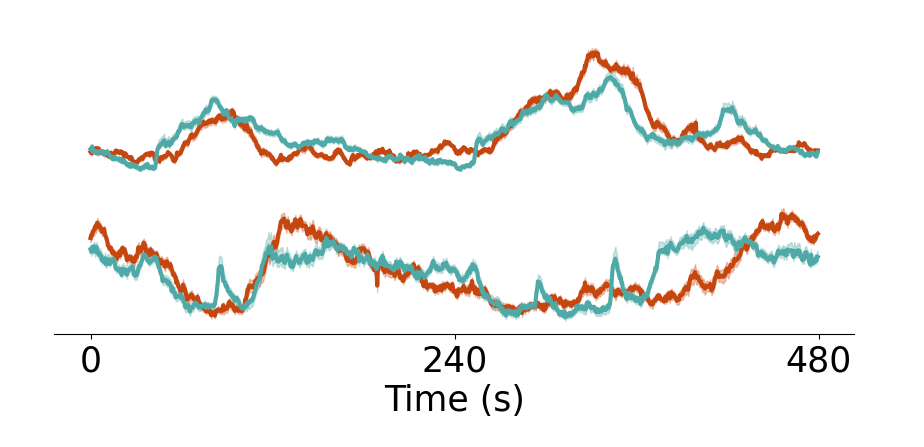

In [47]:
colors = ["#C6460F","#4FAAA7"]
plt.figure()
offset_ = 4
time_vector = np.arange(960)/2
# plt.plot(time_vector,res_reg[960:960*2],"gray",alpha=1,lw=1.5)
# plt.plot(time_vector,res_reg[960:960*2]+offset_,"gray",alpha=1,lw=1.5)

plt.plot(time_vector,clusters_mean[1,:960],c=colors[0],lw=3,label="Temperature Session")
plt.fill_between(time_vector,clusters_mean[1,:960]-clusters_sem[1,:960],
                 clusters_mean[1,:960]+clusters_sem[1,:960],
                 color=colors[0],alpha=.3)
plt.plot(time_vector,clusters_mean[1,960:],c=colors[1],lw=3,label="Salt Session")
plt.fill_between(time_vector,clusters_mean[1,960:]-clusters_sem[1,:960],
                 clusters_mean[1,960:]+clusters_sem[1,960:],
                 color=colors[1],alpha=.3)

plt.plot(time_vector,clusters_mean[0,:960]+offset_,c=colors[0],lw=3)
plt.fill_between(time_vector,clusters_mean[0,:960]+offset_-clusters_sem[0,:960],
                 clusters_mean[0,:960]+offset_+clusters_sem[0,:960],
                 color=colors[0],alpha=.3)
plt.plot(time_vector,clusters_mean[0,960:]+offset_,c=colors[1],lw=3)
plt.fill_between(time_vector,clusters_mean[0,960:]+offset_-clusters_sem[0,:960],
                 clusters_mean[0,960:]+offset_+clusters_sem[0,960:],
                 color=colors[1],alpha=.3)
sns.despine(left=True)
plt.yticks([])
plt.xticks([0,240,480],fontsize=25)
plt.xlabel("Time (s)",fontsize=25)
plt.tight_layout()
plt.show()
set_size(8,3)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\fig_3d_newnew.png",dpi=800)

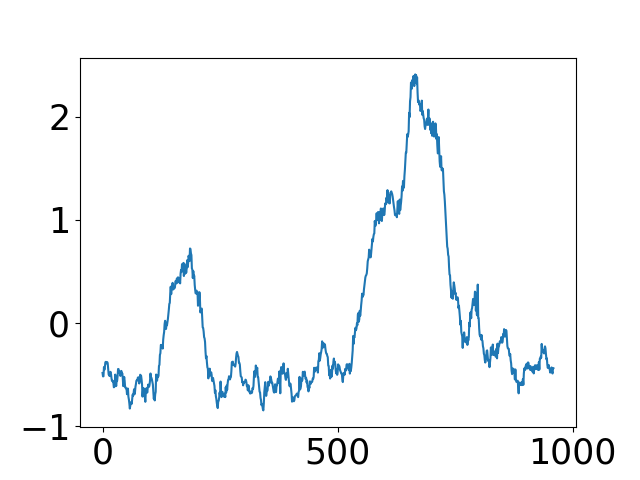

In [66]:
plt.figure()

plt.plot(clusters_mean[0,:960])
plt.show()

In [67]:
0.74+0.6

1.3399999999999999

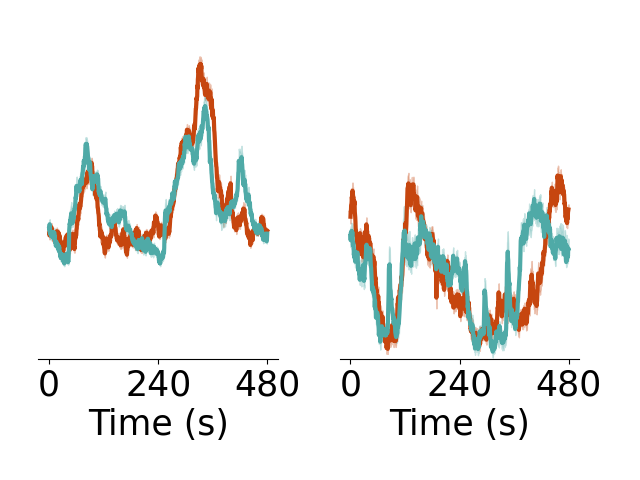

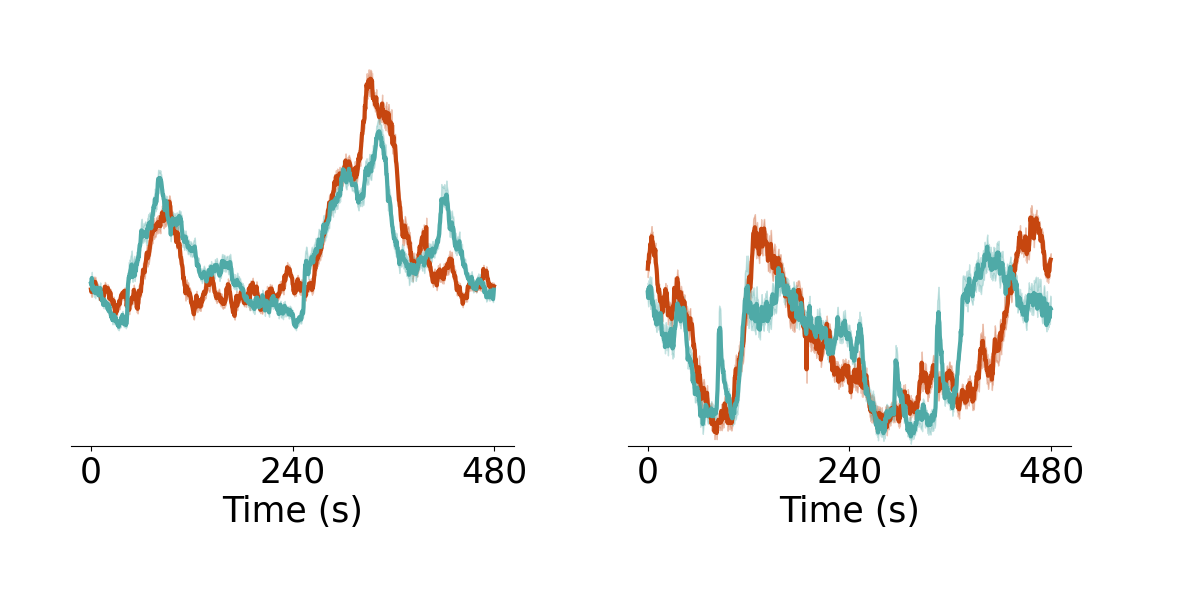

In [65]:
colors = ["#C6460F","#4FAAA7"]
f,a  = plt.subplots(1,2)
offset_ = 4
time_vector = np.arange(960)/2
# plt.plot(time_vector,res_reg[960:960*2],"gray",alpha=1,lw=1.5)
# plt.plot(time_vector,res_reg[960:960*2]+offset_,"gray",alpha=1,lw=1.5)
offset = -np.nanmean(clusters_mean[1,40:80]).mean()
a[1].plot(time_vector,clusters_mean[1,:960]+offset,c=colors[0],lw=3,label="Temperature Session")
a[1].fill_between(time_vector,clusters_mean[1,:960]+offset-clusters_sem[1,:960],
                 clusters_mean[1,:960]+offset+clusters_sem[1,:960],
                 color=colors[0],alpha=.3)
a[1].plot(time_vector,clusters_mean[1,960:]+offset,c=colors[1],lw=3,label="Salt Session")
a[1].fill_between(time_vector,clusters_mean[1,960:]+offset-clusters_sem[1,:960],
                 clusters_mean[1,960:]+offset+clusters_sem[1,960:],
                 color=colors[1],alpha=.3)
offset_ = -np.nanmean(clusters_mean[0,40:80]).mean()
a[0].plot(time_vector,clusters_mean[0,:960]+offset_,c=colors[0],lw=3)
a[0].fill_between(time_vector,clusters_mean[0,:960]+offset_-clusters_sem[0,:960],
                 clusters_mean[0,:960]+offset_+clusters_sem[0,:960],
                 color=colors[0],alpha=.3)
a[0].plot(time_vector,clusters_mean[0,960:]+offset_,c=colors[1],lw=3)
a[0].fill_between(time_vector,clusters_mean[0,960:]+offset_-clusters_sem[0,:960],
                 clusters_mean[0,960:]+offset_+clusters_sem[0,960:],
                 color=colors[1],alpha=.3)
sns.despine(left=True)
a[0].set_ylim([-2,3.5])
a[1].set_ylim([-2,3.5])
a[0].set_yticks([])
a[0].set_xticks([0,240,480])
a[0].set_xticklabels([0,240,480],fontsize=25)
a[0].set_xlabel("Time (s)",fontsize=25)
a[1].set_yticks([])
a[1].set_xticks([0,240,480])
a[1].set_xticklabels([0,240,480],fontsize=25)
a[1].set_xlabel("Time (s)",fontsize=25)
plt.tight_layout()
plt.show()
set_size(10,4)
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\panels_afterreview\fig_3d_newnewnew.png",dpi=800)